# SOTA CNN for Computer Vision

Implementation in pytorch

## VGG 

![1 B_ZaaaBg2njhp8SThjCufA.png](<attachment:1 B_ZaaaBg2njhp8SThjCufA.png>)
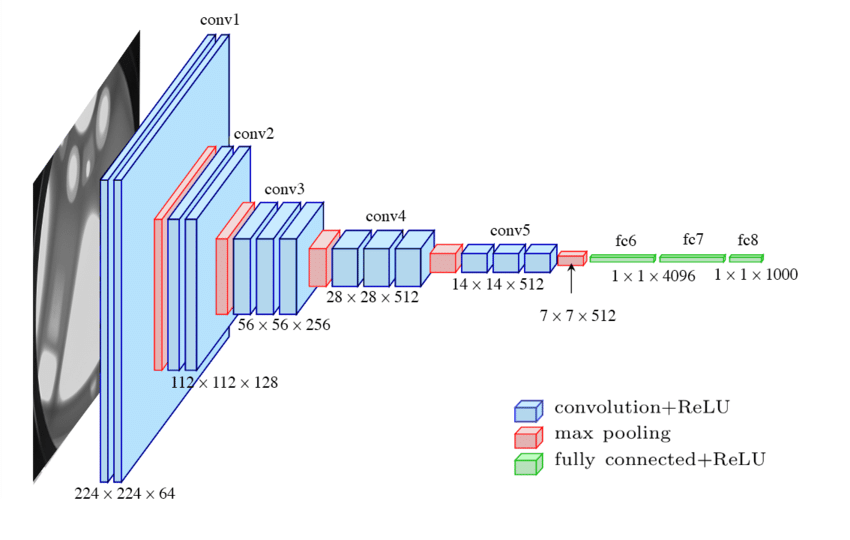

In [ ]:
import torch.nn as nn


class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()

        # Feature extraction layers: Convolutional and pooling layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=3, padding=1
            ),  # 3 input channels, 64 output channels, 3x3 kernel, 1 padding
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # Max pooling with 2x2 kernel and stride 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(
                512 * 7 * 7, 4096
            ),  # 512 channels, 7x7 spatial dimensions after max pooling
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer with 0.5 dropout probability
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # Output layer with 'num_classes' output units
        )

    def forward(self, x):
        x = self.feature_extractor(x)  # Pass input through the feature extractor layers
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass flattened output through the classifier layers
        return x

## GoogleNet

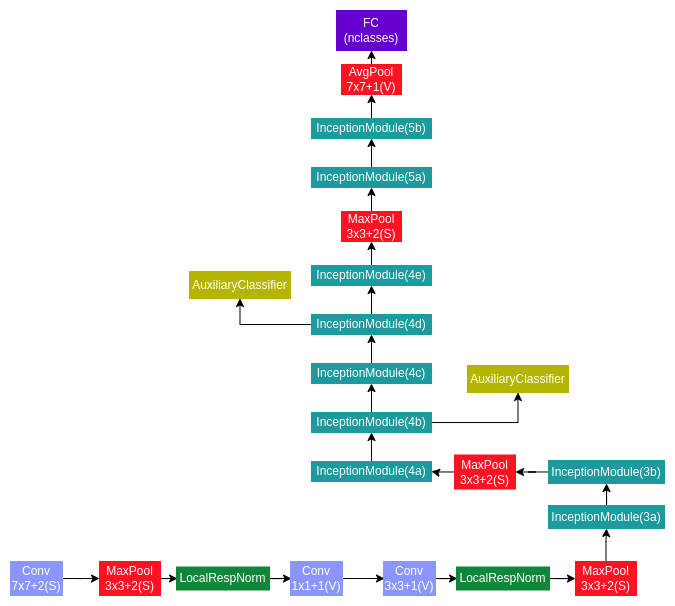

In [ ]:
import torch
import torch.nn as nn


class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.b1 = BaseConv2d(in_channels, n1x1, kernel_size=1)

        self.b2 = nn.Sequential(
            BaseConv2d(in_channels, n3x3red, kernel_size=1),
            BaseConv2d(n3x3red, n3x3, kernel_size=3, padding=1),
        )

        self.b3 = nn.Sequential(
            BaseConv2d(in_channels, n5x5red, kernel_size=1),
            BaseConv2d(n5x5red, n5x5, kernel_size=5, padding=2),
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            BaseConv2d(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)


class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, dropout=0.7):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AvgPool2d(5, stride=3)
        self.conv = BaseConv2d(in_channels, 128, kernel_size=1)
        self.relu = nn.ReLU(True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class GoogLeNet(nn.Module):
    def __init__(self, use_aux=True):
        super(GoogLeNet, self).__init__()

        self.use_aux = use_aux
        ## block 1
        self.conv1 = BaseConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 2
        self.conv2 = BaseConv2d(64, 64, kernel_size=1)
        self.conv3 = BaseConv2d(64, 192, kernel_size=3, padding=1)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 3
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 4
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 5
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        ## auxiliary classifier
        if self.use_aux:
            self.aux1 = AuxiliaryClassifier(512, 1000)
            self.aux2 = AuxiliaryClassifier(528, 1000)

        ## block 6
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 1000)

    def forward(self, x):
        ## block 1
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.lrn1(x)

        ## block 2
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.lrn2(x)
        x = self.maxpool2(x)

        ## block 3
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        ## block 4
        x = self.inception4a(x)
        if self.use_aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.use_aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        ## block 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        ## block 6
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.use_aux:
            return x, aux1, aux2
        else:
            return x

##  MobileNet

In [ ]:
## with pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=in_channels,
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)

        # MobileNet body
        self.dw_conv2 = DepthwiseSeparableConv(32, 64, 1)
        self.dw_conv3 = DepthwiseSeparableConv(64, 128, 2)
        self.dw_conv4 = DepthwiseSeparableConv(128, 128, 1)
        self.dw_conv5 = DepthwiseSeparableConv(128, 256, 2)
        self.dw_conv6 = DepthwiseSeparableConv(256, 256, 1)
        self.dw_conv7 = DepthwiseSeparableConv(256, 512, 2)

        # 5 depthwise separable convolutions with stride 1
        self.dw_conv8 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv9 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv10 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv11 = DepthwiseSeparableConv(512, 512, 1)
        self.dw_conv12 = DepthwiseSeparableConv(512, 512, 1)

        self.dw_conv13 = DepthwiseSeparableConv(512, 1024, 2)
        self.dw_conv14 = DepthwiseSeparableConv(1024, 1024, 1)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.dw_conv2(x)
        x = F.relu(x)
        x = self.dw_conv3(x)
        x = F.relu(x)
        x = self.dw_conv4(x)
        x = F.relu(x)
        x = self.dw_conv5(x)
        x = F.relu(x)
        x = self.dw_conv6(x)
        x = F.relu(x)
        x = self.dw_conv7(x)
        x = F.relu(x)

        x = self.dw_conv8(x)
        x = F.relu(x)
        x = self.dw_conv9(x)
        x = F.relu(x)
        x = self.dw_conv10(x)
        x = F.relu(x)
        x = self.dw_conv11(x)
        x = F.relu(x)
        x = self.dw_conv12(x)
        x = F.relu(x)

        x = self.dw_conv13(x)
        x = F.relu(x)
        x = self.dw_conv14(x)
        x = F.relu(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Create the model
mobilenet = MobileNet(num_classes=1000)
print(mobilenet)

In [ ]:
## MobileNet with HuggingFace

from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# initialize processor and model
preprocessor = AutoImageProcessor.from_pretrained("google/mobilenet_v2_1.0_224")
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

# preprocess the inputs
inputs = preprocessor(images=image, return_tensors="pt")

# get the output and the class labels
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

## ConvNext - A ConvNet for the 2020s (2022)
Use hugging Face pipeline: https://huggingface.co/docs/transformers/model_doc/convnext

##  ResNet 
Hugging Face Code

In [ ]:
from transformers import ResNetForImageClassification
## pre-trained model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

model.eval()

All pre-trained models expect input images normalized similarly, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded into a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])